 # Part 3: CycleGAN

Setting up the environment and helper functions

In [1]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display
import numpy as np
import PIL.Image
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def interpolate(A, B, num_interps):
    alphas = np.linspace(0, 1, num_interps)
    return np.array([(1-a)*A + a*B for a in alphas])

def imgrid(imarray, cols=5, pad=1):
    if isinstance(imarray, np.ndarray):
        N, H, W, C = imarray.shape
    if isinstance(imarray, list):
        N = len(imarray)
    rows = N // cols + int(N % cols != 0)
    for i in range(N):
        plt.subplot(rows, cols, i+1)
        plt.title("%d"%i)
        plt.imshow(imarray[i])
        plt.axis('off')
        
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
    """Loads and preprocesses images."""
    # Cache image file locally.
    image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
    # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
    img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...] / 255.
    if img.shape[-1] == 4:
        img = img[..., :3] / tf.expand_dims(img[..., 3], -1) # pre multiply alpha
        
    if image_size[0] != -1:
        img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
    return img

Downloading the model and hacking at the Protobuf (frozen graph)

In [ ]:
# Download the pretrained horse2zebra model
!wget https://github.com/vanhuyz/CycleGAN-TensorFlow/releases/download/v0.1-alpha/horse2zebra.pb --no-check-certificate

In [3]:
tf.reset_default_graph()

In [4]:
graph = tf.Graph()
with graph.as_default():
    with tf.gfile.GFile('horse2zebra.pb', 'rb') as model_file:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(model_file.read())
        tf.import_graph_def(graph_def)

In [5]:
# look at the first few and last few oprations
graph.get_operations()[:5],graph.get_operations()[-5:]

([<tf.Operation 'import/input_image' type=Placeholder>,
  <tf.Operation 'import/G/c7s1_32/weights' type=Const>,
  <tf.Operation 'import/G/c7s1_32/weights/read' type=Identity>,
  <tf.Operation 'import/G/c7s1_32/instance_norm/scale' type=Const>,
  <tf.Operation 'import/G/c7s1_32/instance_norm/scale/read' type=Identity>],
 [<tf.Operation 'import/map_4/TensorArrayStack/range' type=Range>,
  <tf.Operation 'import/map_4/TensorArrayStack/TensorArrayGatherV3' type=TensorArrayGatherV3>,
  <tf.Operation 'import/Squeeze' type=Squeeze>,
  <tf.Operation 'import/EncodeJpeg' type=EncodeJpeg>,
  <tf.Operation 'import/output_image' type=Identity>])

In [5]:
def inference(image_url):
    with tf.Session(graph=graph) as sess:
        # load the image
        image = load_image(image_url)
        image = tf.image.resize_images(image, size=(256, 256))
        image = tf.squeeze(tf.cast(image, tf.float32))
        image_array = sess.run(image)
        
        # run the graph between the 'input_image' and 'Squeeze' operations.
        generated = sess.run('import/Squeeze:0', feed_dict={'import/input_image:0': image_array})

        plt.figure(figsize=(12,5))
        plt.subplot(121),plt.imshow(image_array)
        plt.subplot(122),plt.imshow(generated)

 557056/Unknown - 0s 1us/step

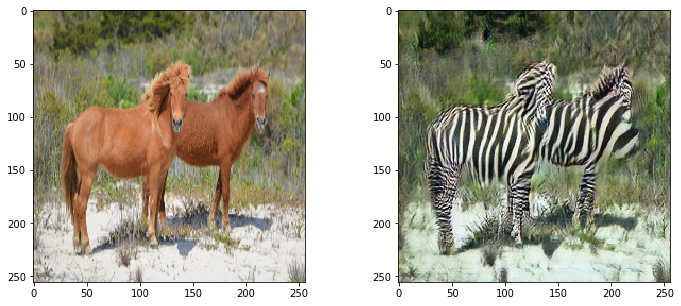

In [7]:
inference('https://www.nps.gov/asis/learn/news/images/horses.png')

# Task1: 
### Bring a horse image of your own and run the horse2zebra model

73728/71069 [===============================] - 0s 1us/step


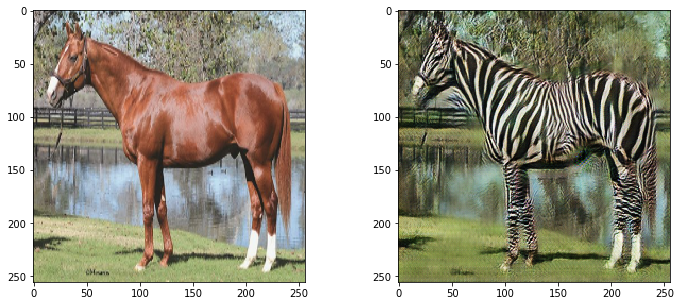

In [6]:
inference('https://cdn.bloodhorse.com/sroimages//medium/0000135487_1.jpg')

## Experimenting with Origami images of Horse

237568/230904 [==============================] - 0s 1us/step


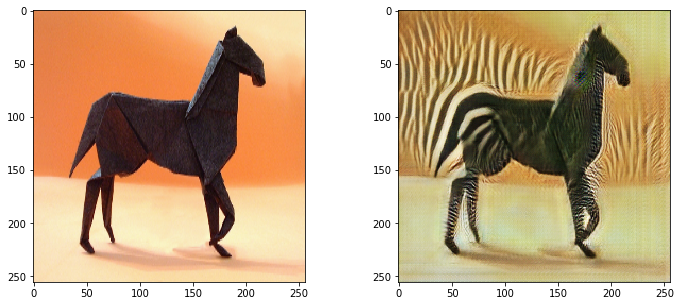

In [6]:
inference('https://www.giladorigami.com/P_Horse_Yoshizawa.JPG')

# Task2:
### Bring another image, not of a horse and see what happens

## a) On a uniform ball (capturing texture)

57344/55344 [===============================] - 0s 0us/step


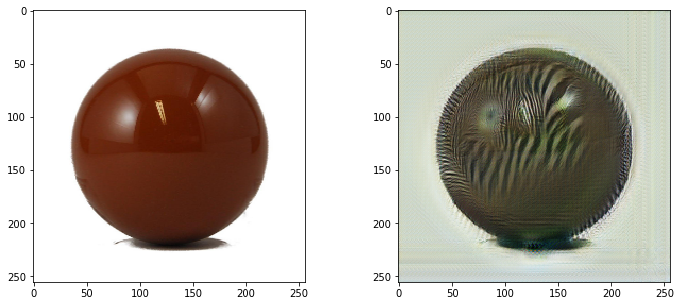

In [6]:
inference('https://images-na.ssl-images-amazon.com/images/I/51ZEx8zSASL._SL1209_.jpg')

## b) On a 'my little pony'

262144/259862 [==============================] - 0s 0us/step


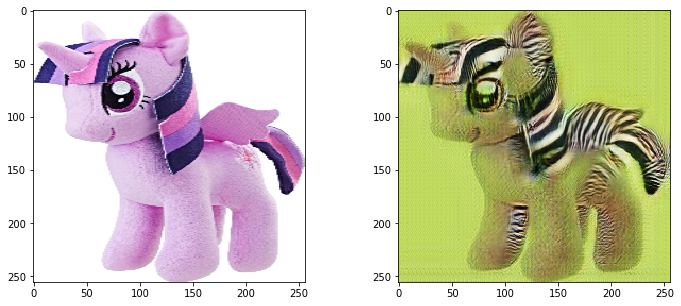

In [6]:
inference('https://pisces.bbystatic.com/image2/BestBuy_US/images/products/6257/6257832_sd.jpg')

## c) Adding zebra style to zebra crossings

3301376/3294193 [==============================] - 1s 0us/step


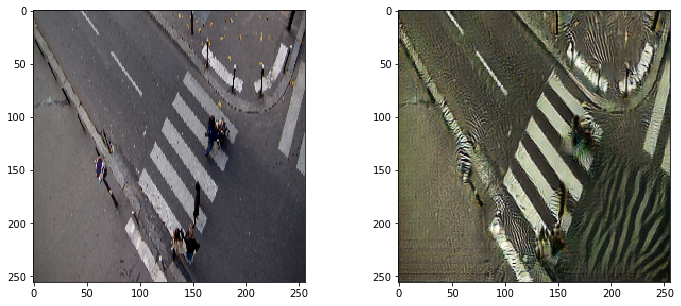

In [6]:
inference('https://upload.wikimedia.org/wikipedia/commons/4/49/Paris_street_corner%2C_from_the_promenade_plantee.jpg')